# Basic Network Regional Models

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src/")
from collections import OrderedDict
import cellbell

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
from models import SimpleDense

from sklearn.model_selection import train_test_split

Using Theano backend.
Using gpu device 0: GeForce GT 630M (CNMeM is disabled, cuDNN not available)


## Data

In [3]:
data_file = "../data/processed/stacking-data.h5"
df = pd.read_hdf(data_file, "data")

## Model

In [4]:
SimpleDense(1, 4).model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 1, 10)         540         embedding_input_1[0][0]          
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 10)            0           embedding_1[0][0]                
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 10)            0           flatten_1[0][0]                  
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            110         activation_1[0][0]               
___________________________________________________________________________________________

## Training

Creating one model per score (*peak week*, *onset week*, etc.)

In [5]:
regions = df.index.levels[-1]
scores = df.columns.levels[0]

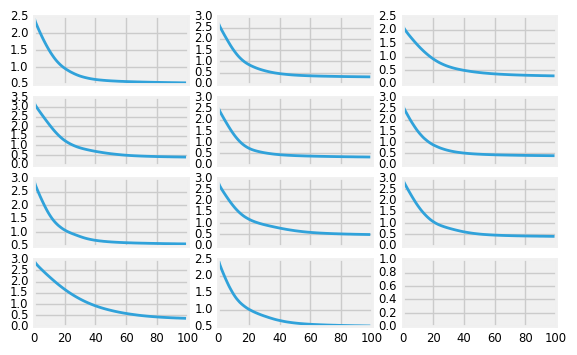

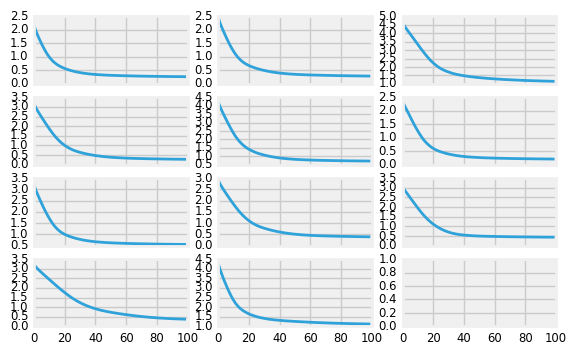

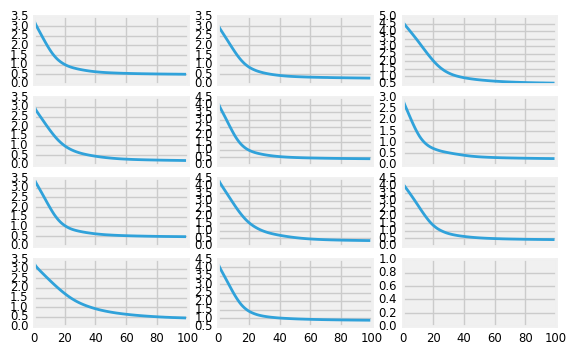

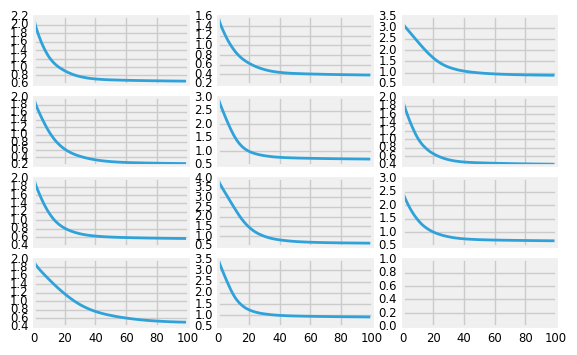

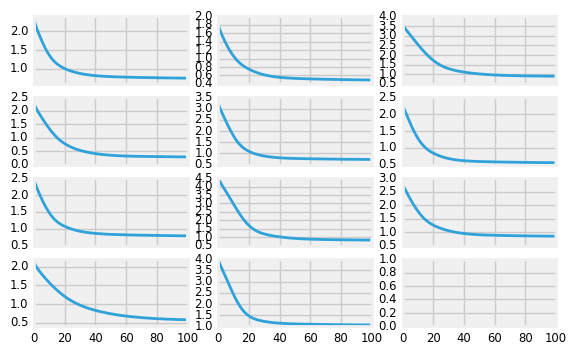

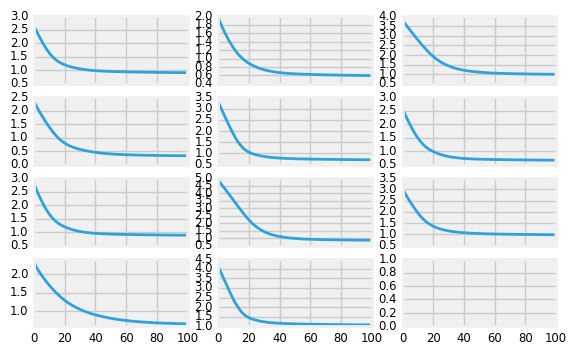

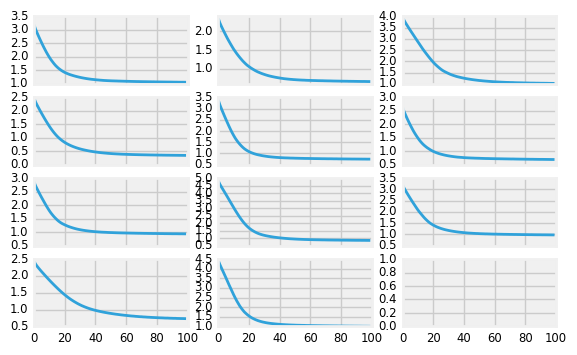

In [6]:
%%ding

models = OrderedDict()

for score in scores:
    subdf = df[score].reset_index()
    models[score] = OrderedDict()
    
    f, axes = plt.subplots(4, 3, sharex=True)
    
    for index, region in enumerate(regions):
        regiondf = subdf[subdf["region"] == region]
        X = regiondf["analysis_time_season_week"].values
        y = regiondf.iloc[:, -4:].as_matrix()
 
        # No validation (data points are less, just checking out results)
        models[score][region] = SimpleDense(1, y.shape[1])
        history = models[score][region].fit(X, y, nb_epoch=100, verbose=0)
    
        idx = int(np.floor(index / 3))
        idy = index % 3
        axes[idx, idy].plot(history.history["loss"], label="loss")
    plt.show()

## Score predictions

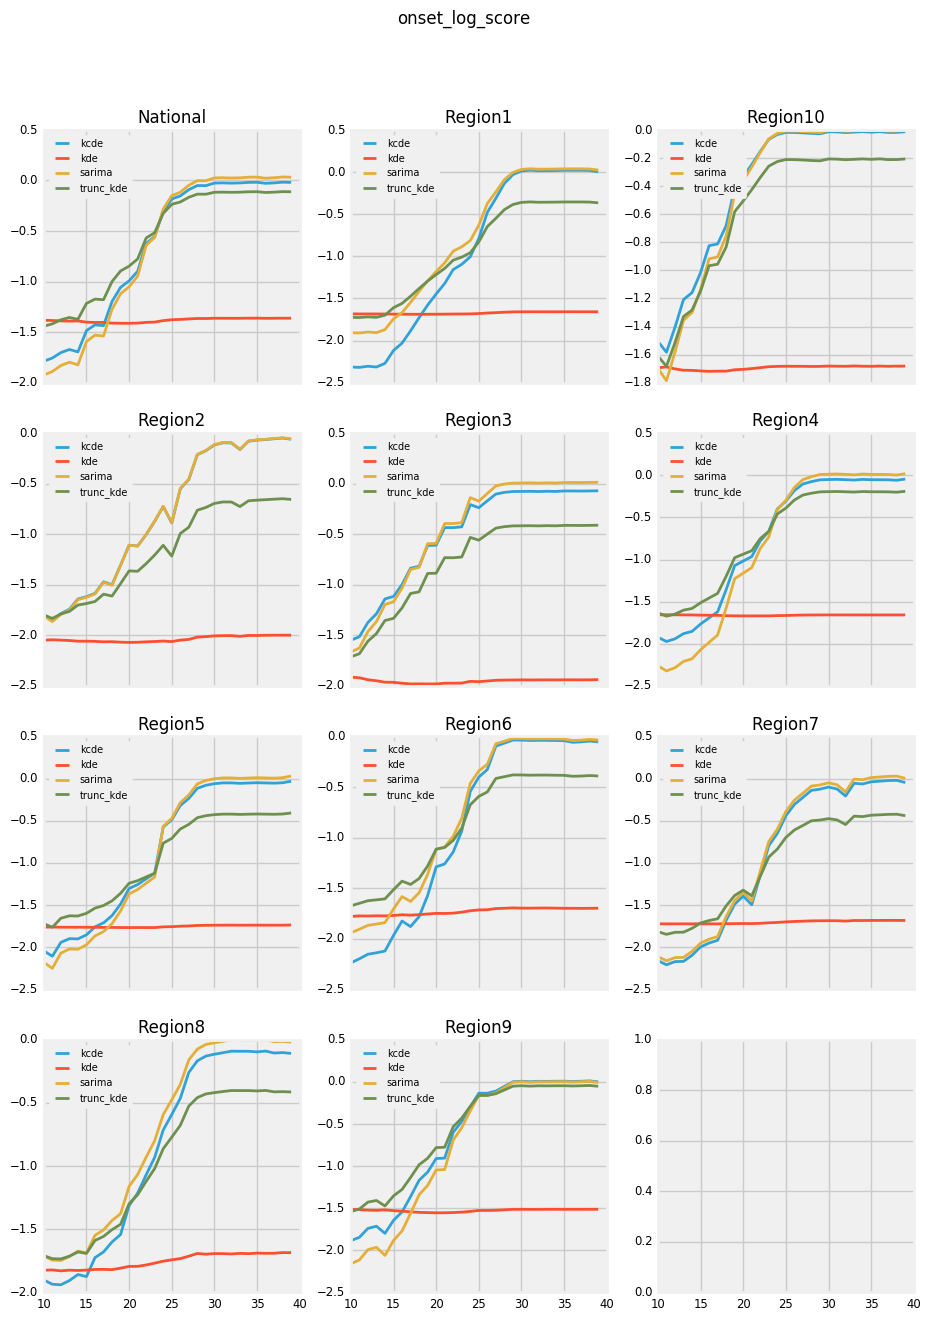

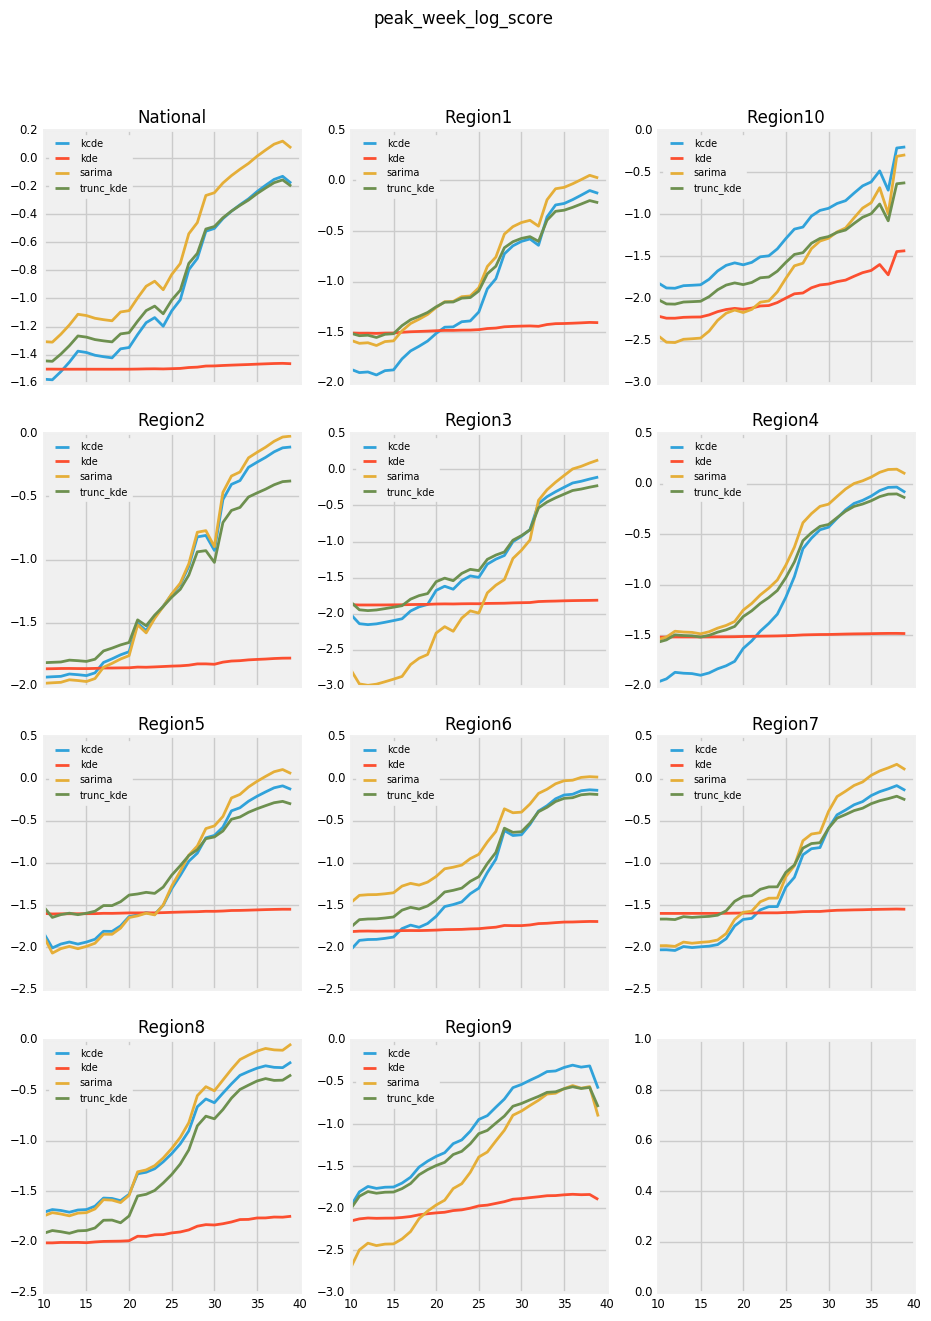

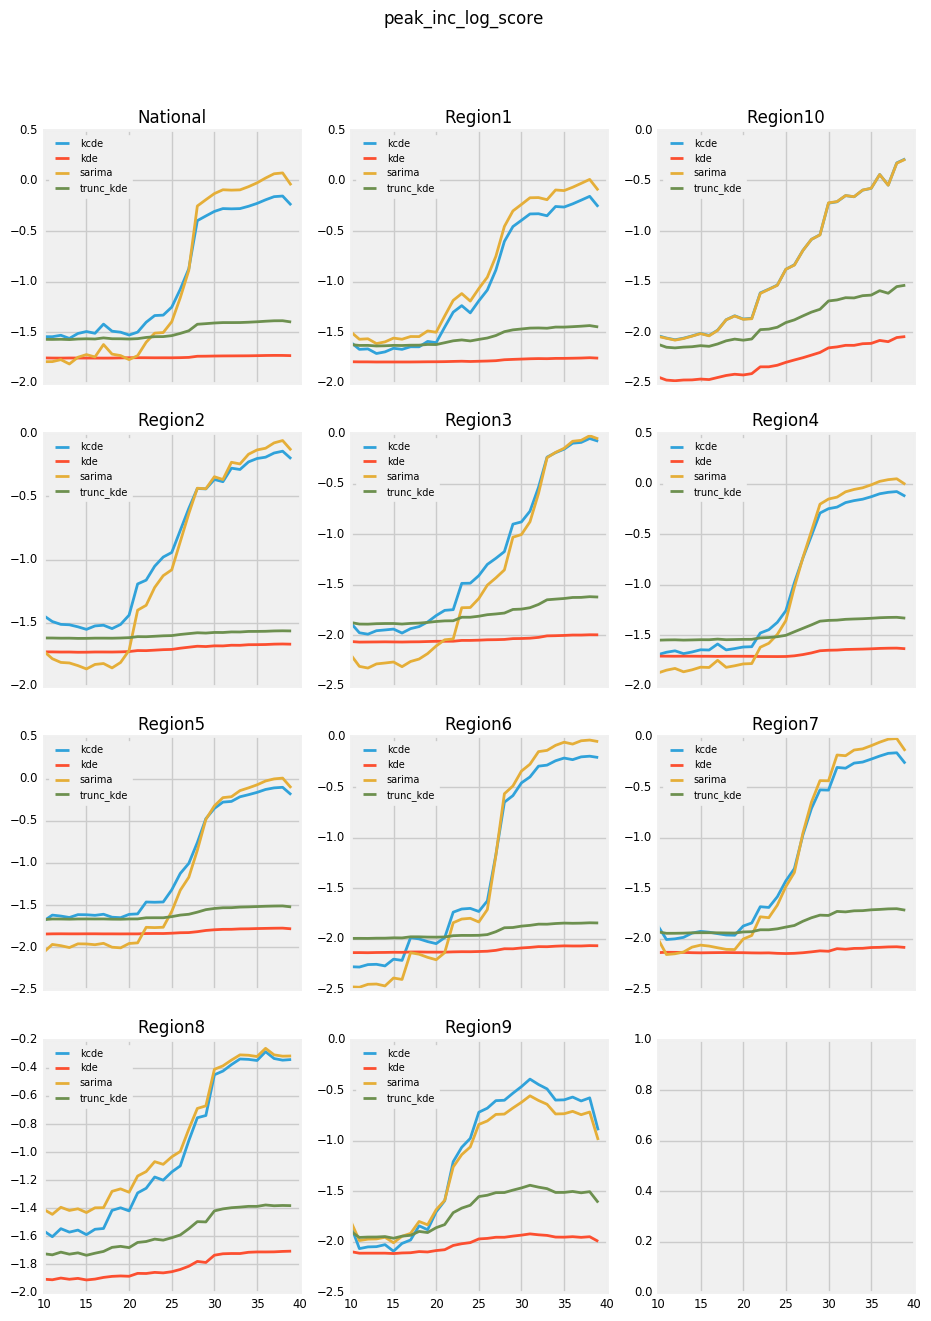

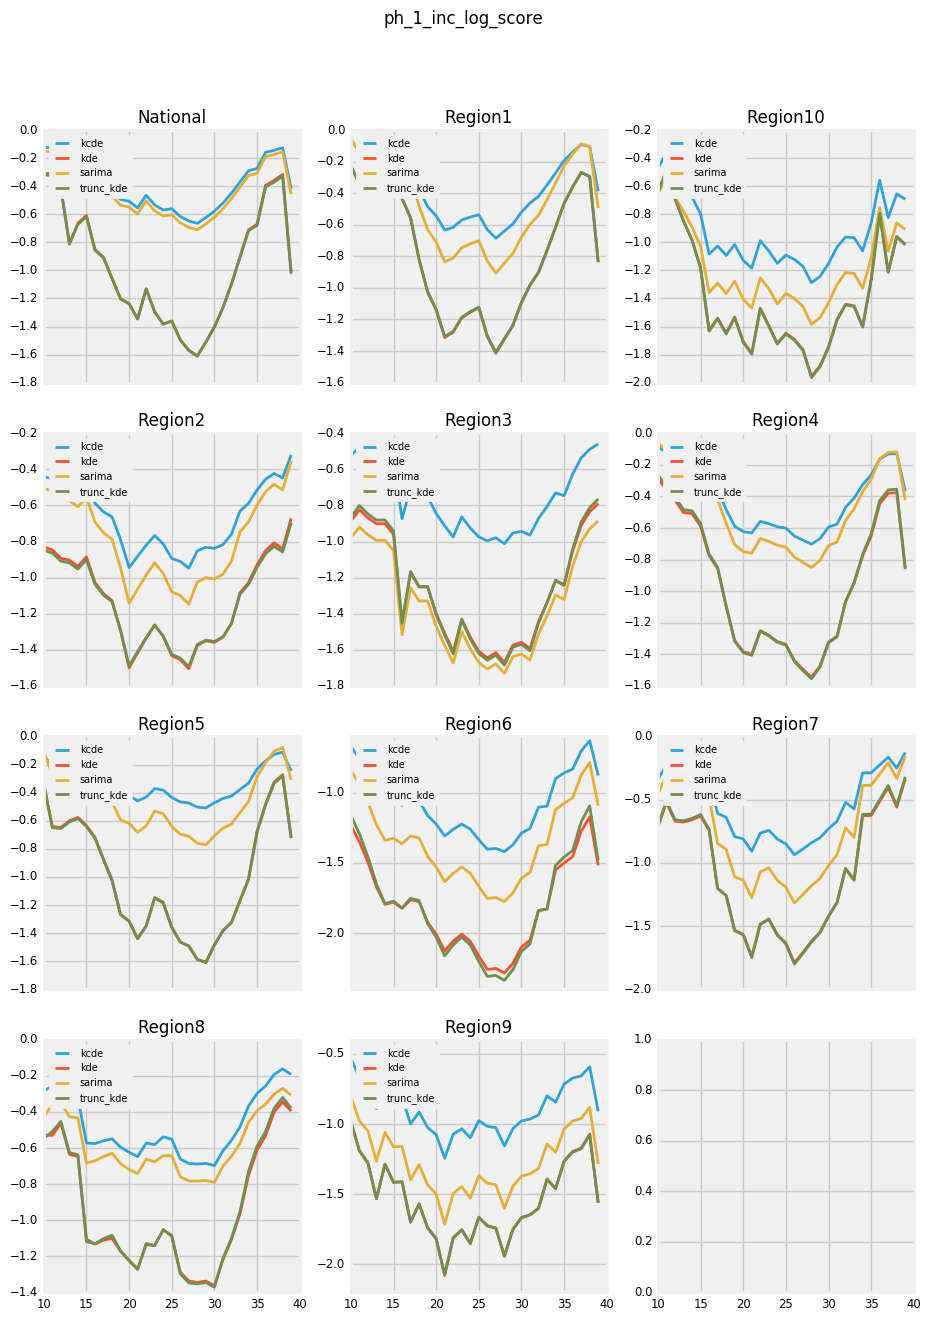

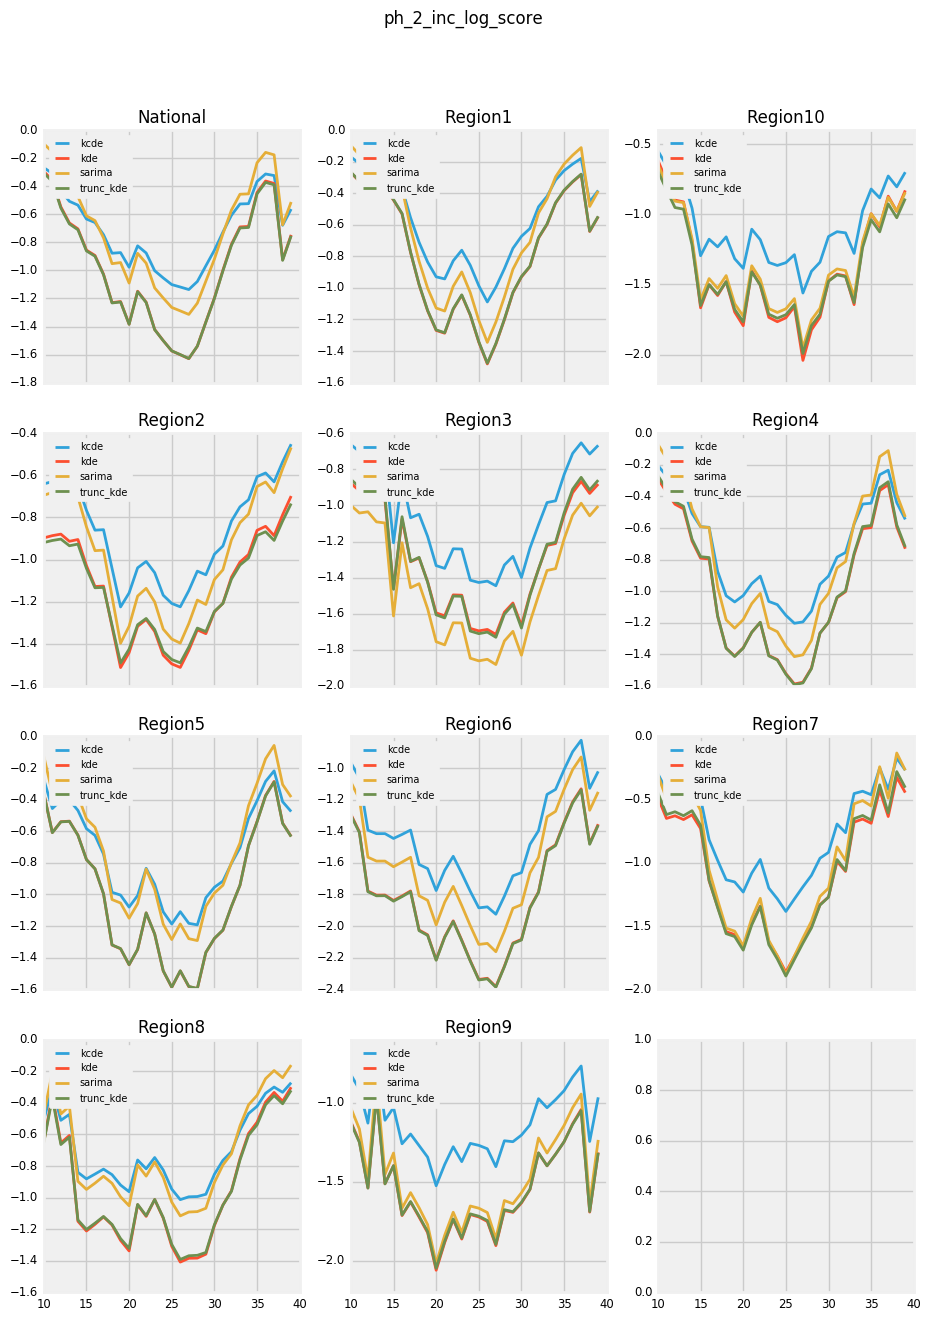

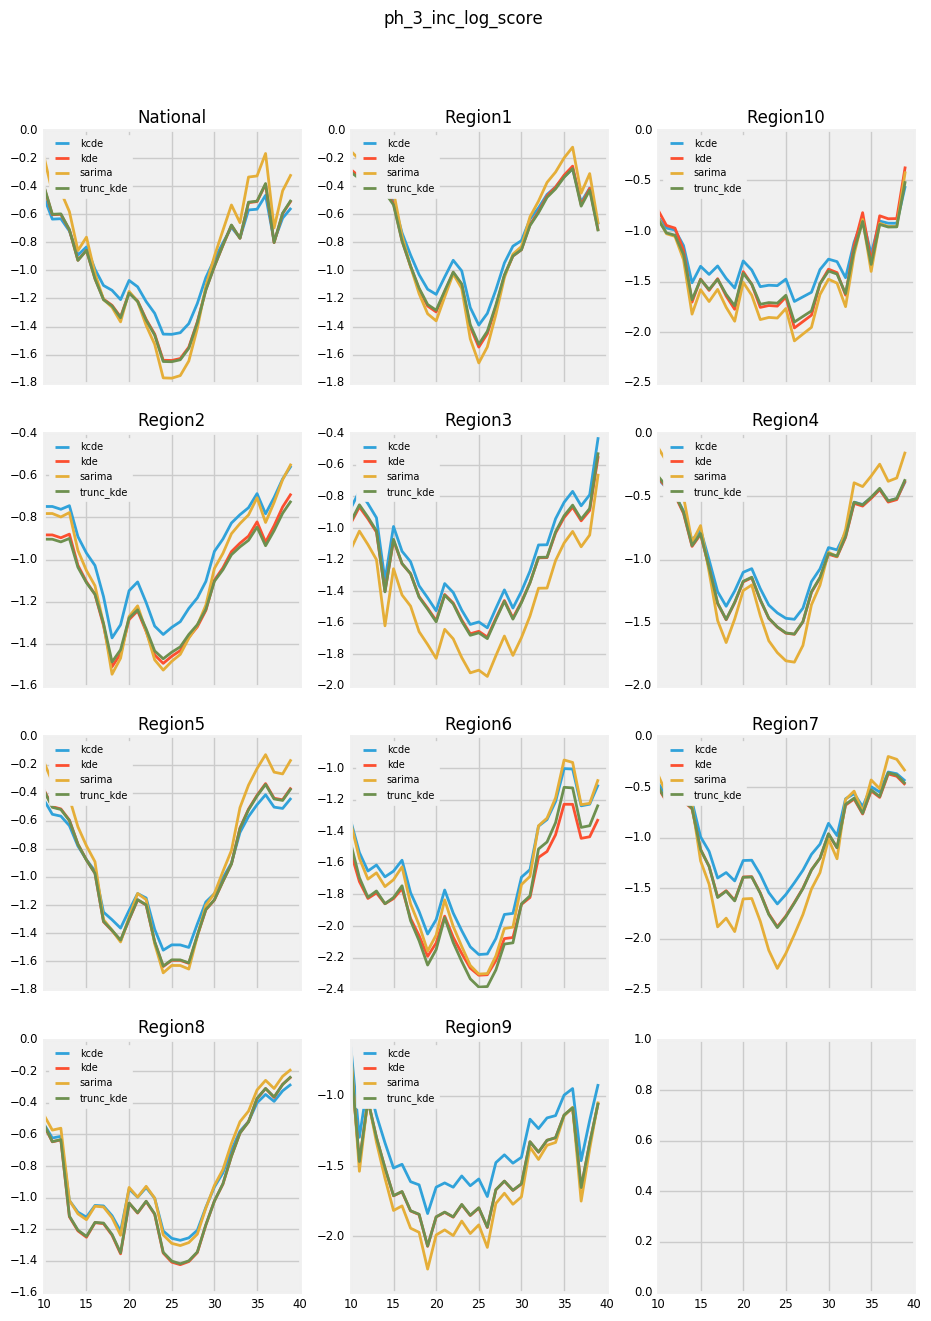

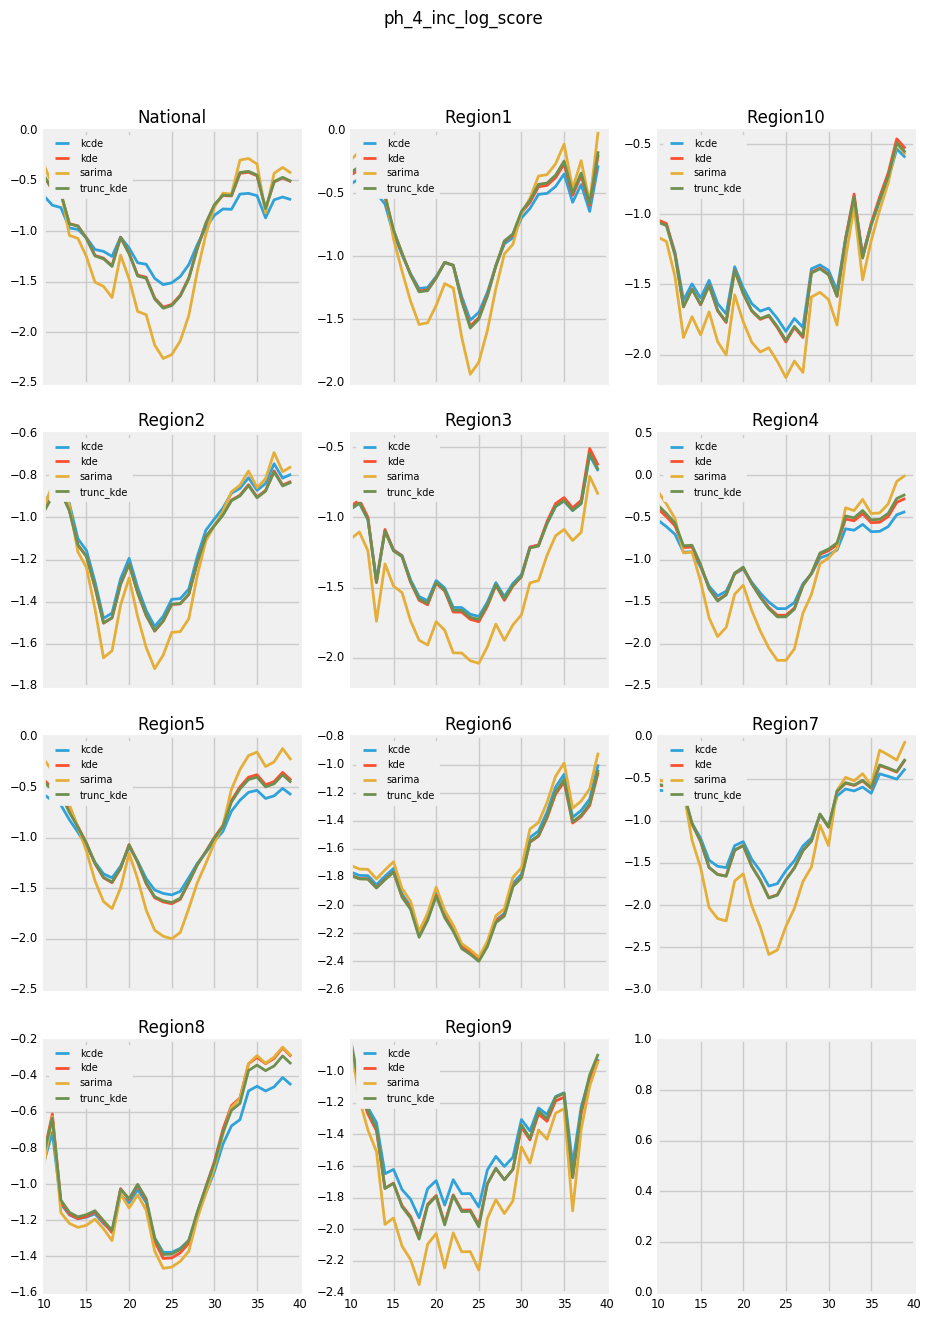

In [7]:
for score, modelDict in models.items():
    
    f, axes = plt.subplots(4, 3, sharex=True, figsize=(10, 15))
    
    for index, (region, model) in enumerate(modelDict.items()):
        weeks = np.arange(10, 40) # Only these weeks are available
        weights = model.predict(weeks)
        
        idx = int(np.floor(index / 3))
        idy = index % 3

        for i, label in enumerate(df["onset_log_score"].columns):
            axes[idx, idy].plot(weeks, weights[:, i], label=label)
        axes[idx, idy].legend(loc="upper left", fontsize=7)
        axes[idx, idy].set_title(region)
    f.suptitle(score)
    plt.show()

## Score to weights

Using softmax with variable temperature factor

Increase beta for harder weight preferences

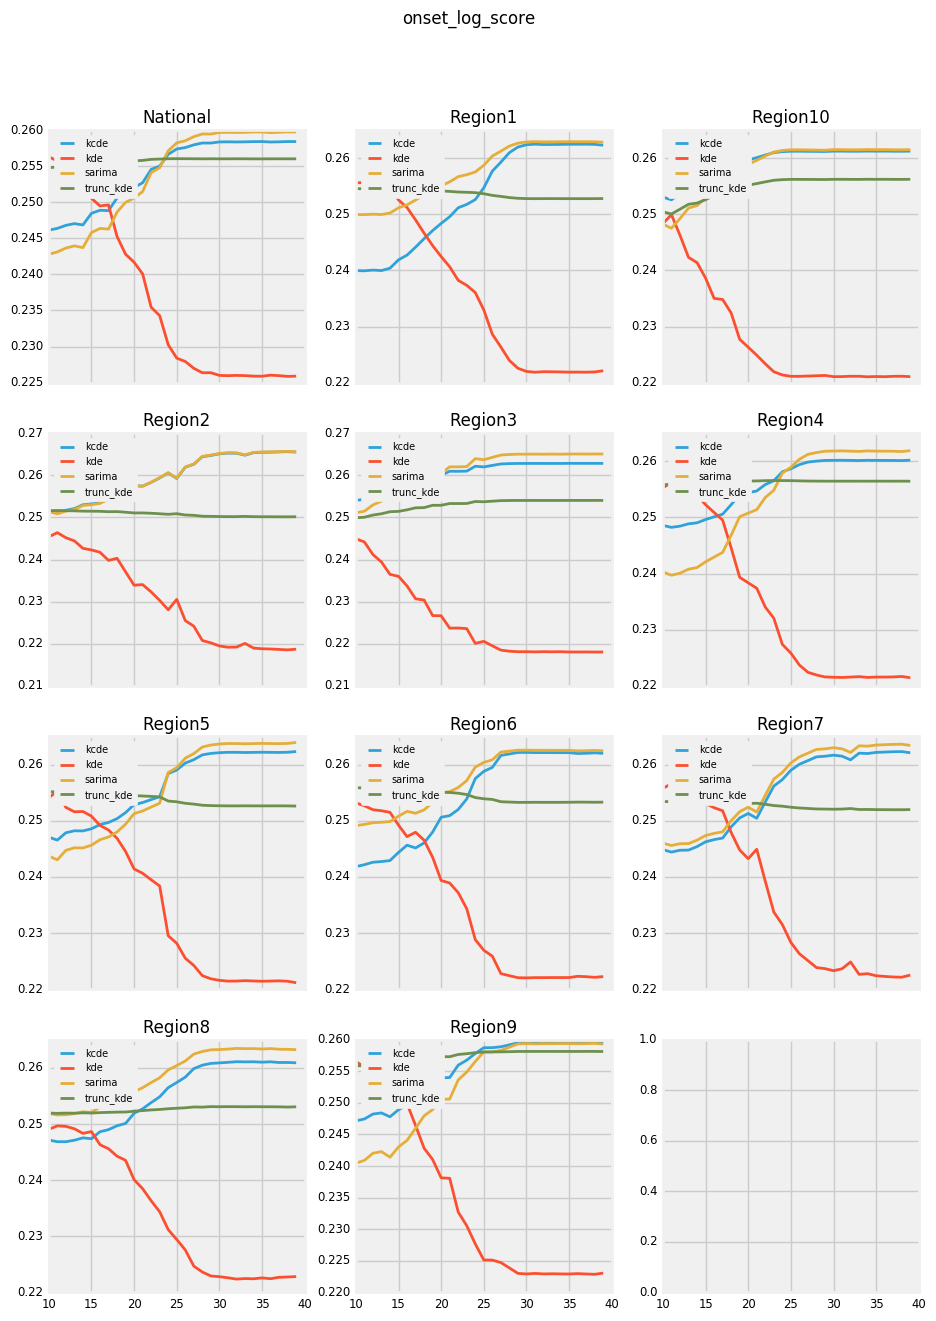

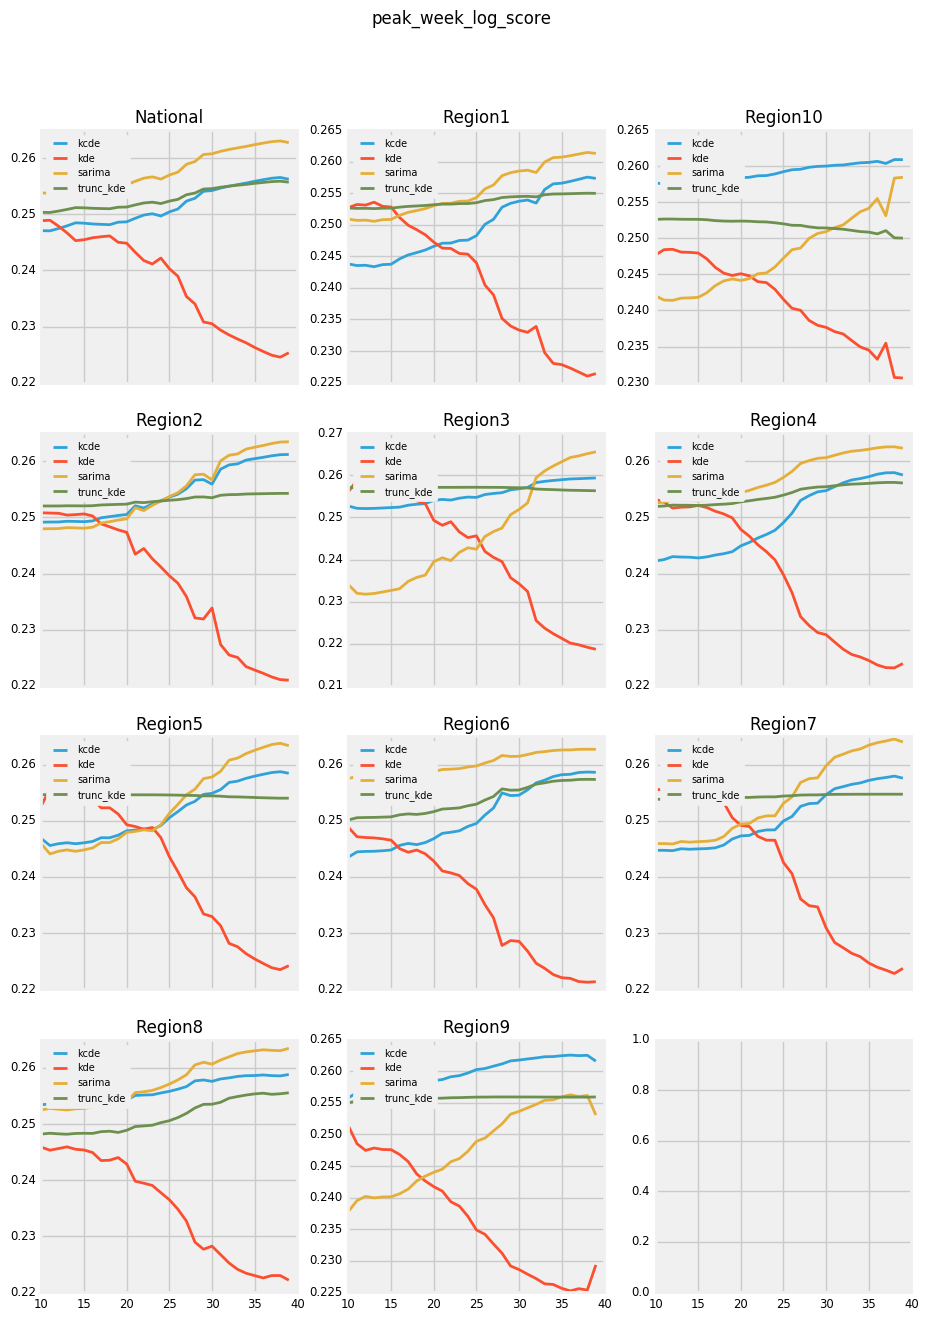

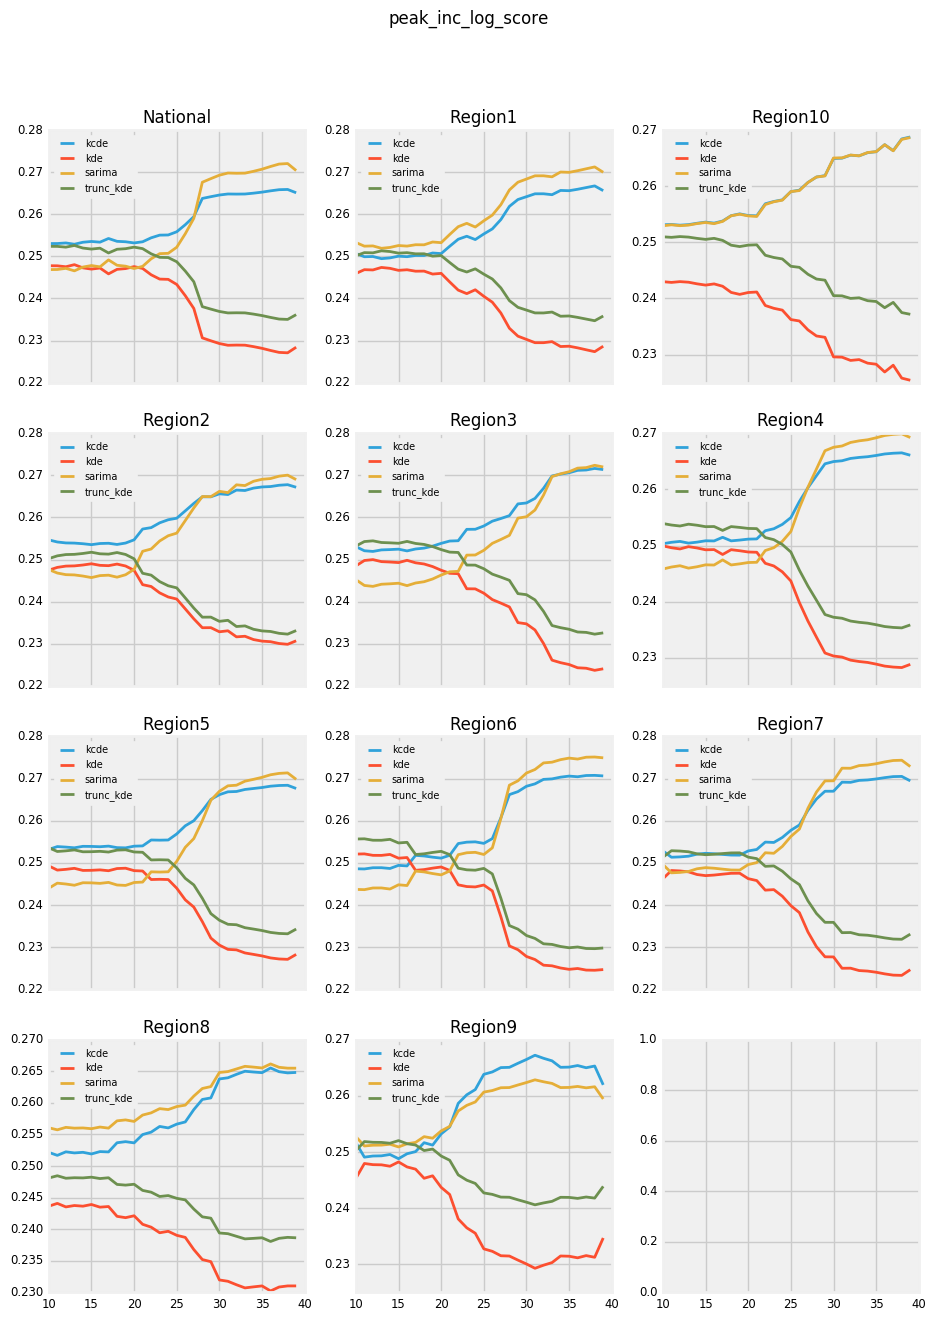

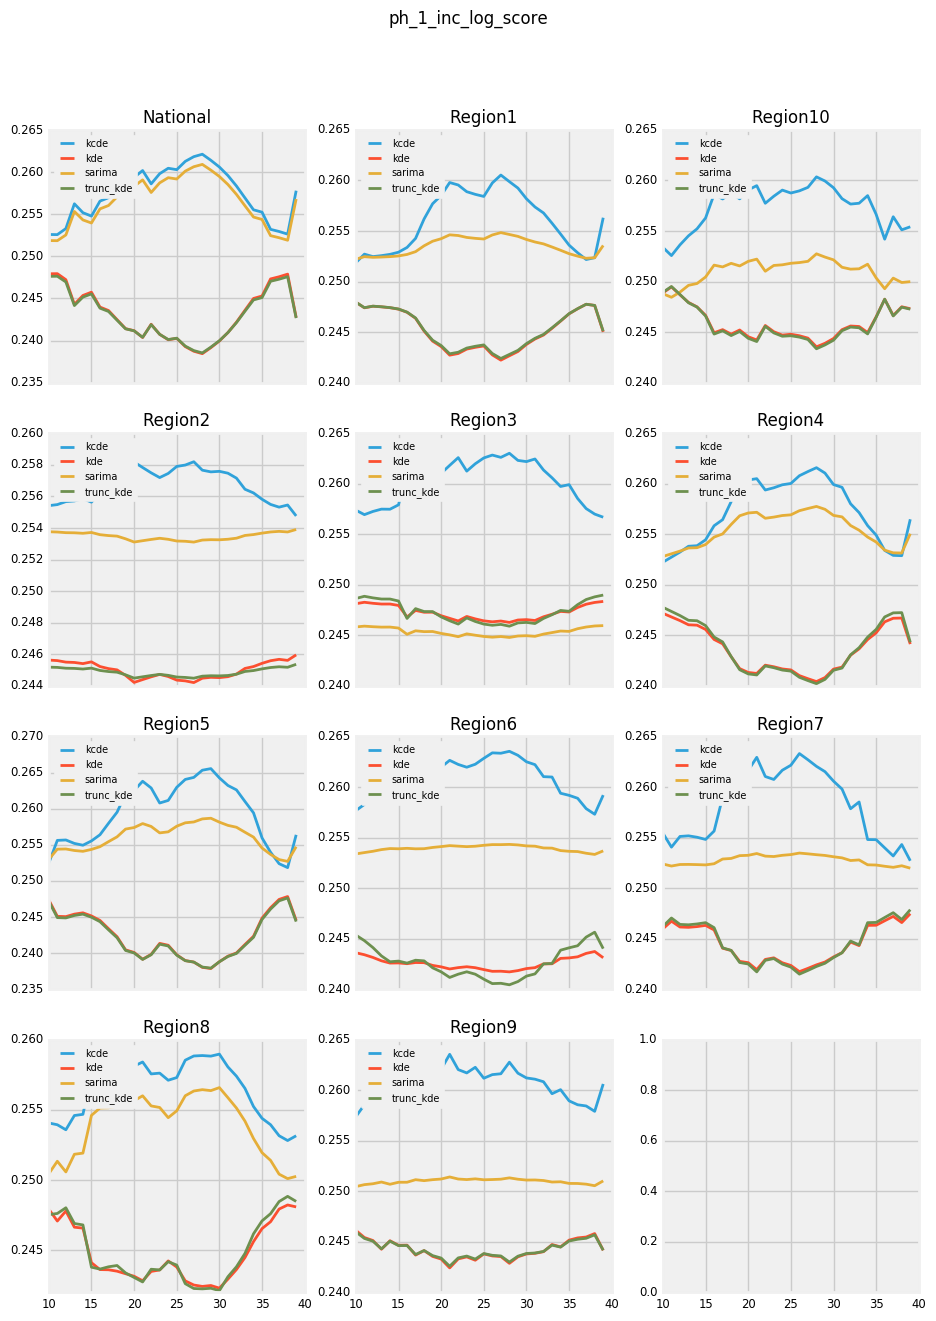

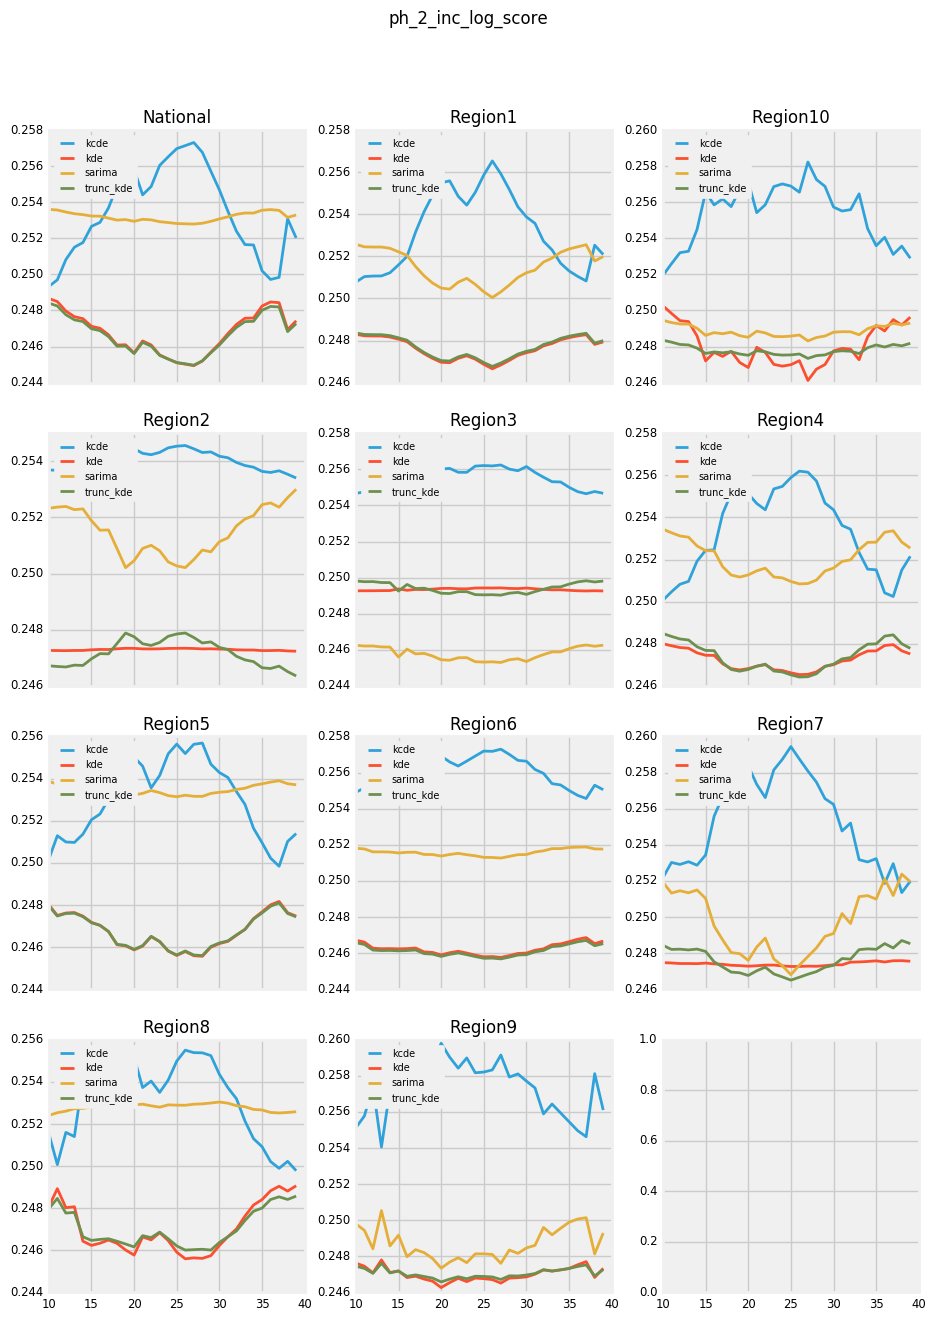

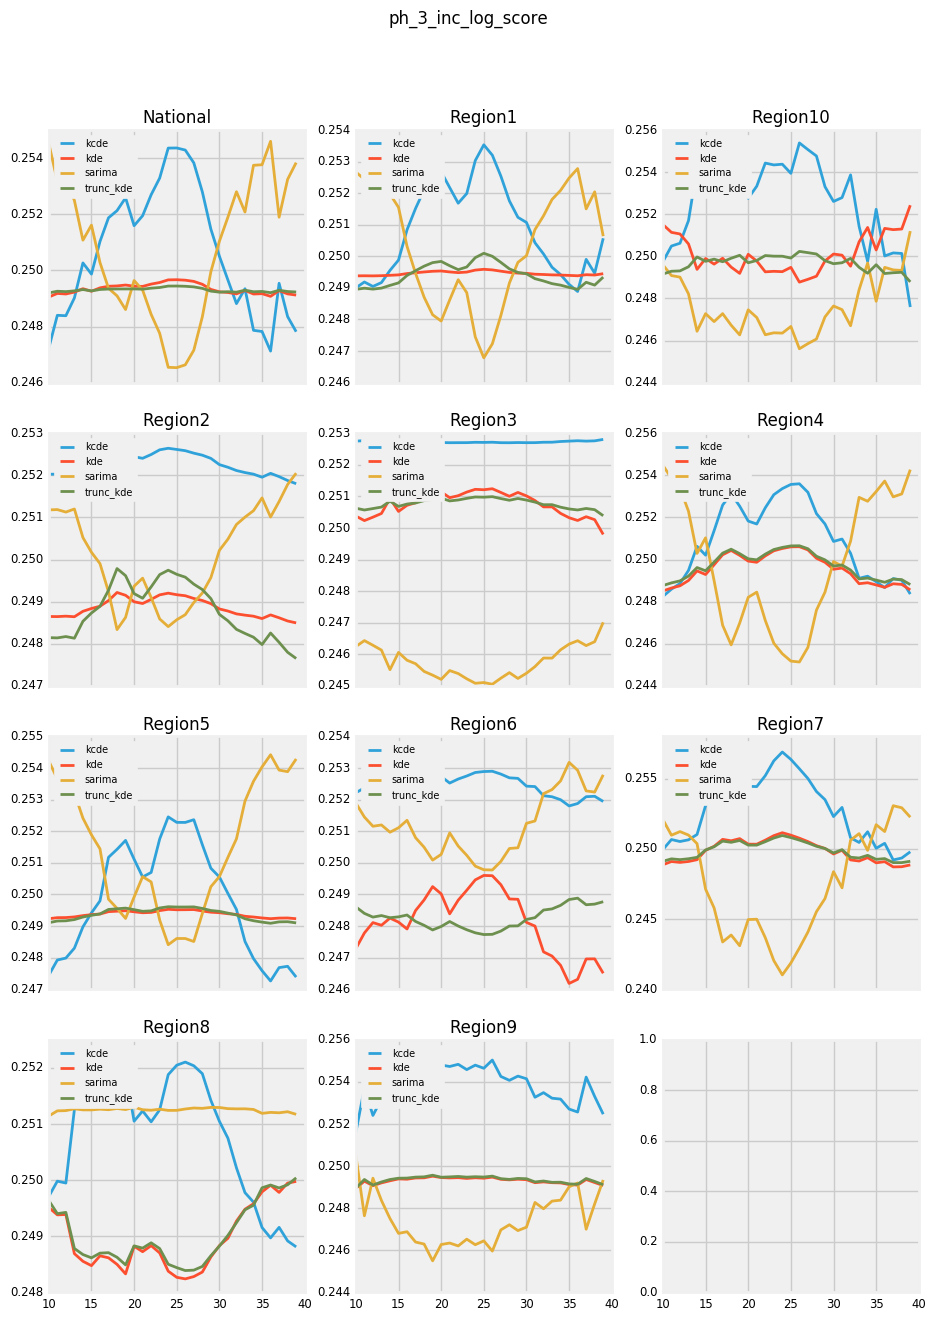

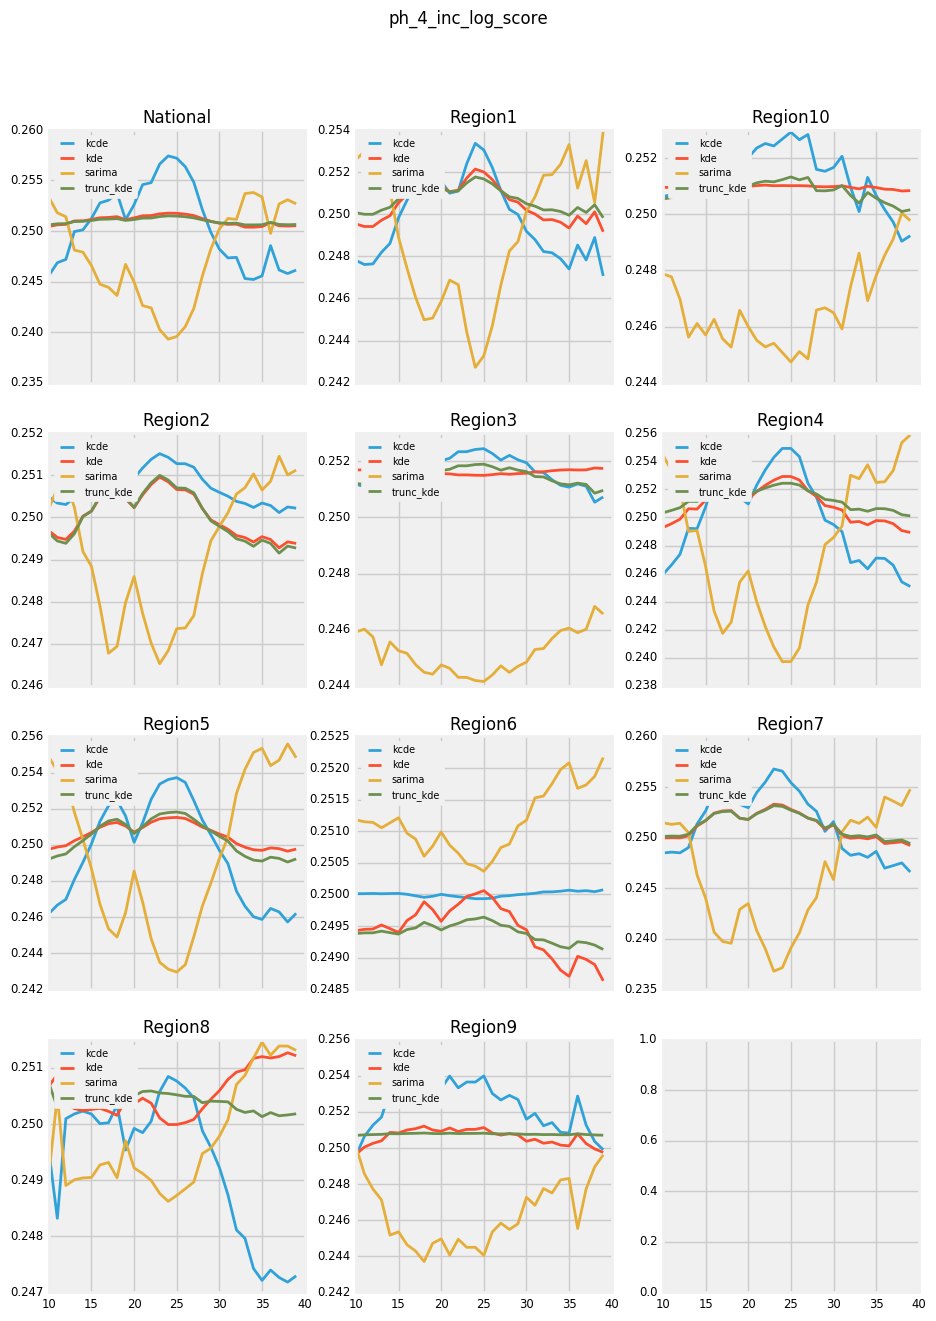

In [9]:
beta = 0.1

for score, modelDict in models.items():
    
    f, axes = plt.subplots(4, 3, sharex=True, figsize=(10, 15))
    
    for index, (region, model) in enumerate(modelDict.items()):
        weeks = np.arange(10, 40) # Only these weeks are available
        weights = np.exp(beta * model.predict(weeks))
    
        weights = weights / weights.sum(axis=1, keepdims=True)
        
        idx = int(np.floor(index / 3))
        idy = index % 3

        for i, label in enumerate(df["onset_log_score"].columns):
            axes[idx, idy].plot(weeks, weights[:, i], label=label)
        axes[idx, idy].legend(loc="upper left", fontsize=7)
        axes[idx, idy].set_title(region)
    f.suptitle(score)
    plt.show()